# Torchaudio

PyTorch is an open source deep learning platform that provides a seamless path from research prototyping to production deployment with GPU support.

Significant effort in solving machine learning problems goes into data preparation. Torchaudio leverages PyTorch’s GPU support, and provides many tools to make data loading easy and more readable. In this tutorial, we will see how to load and preprocess data from a simple dataset.

install torch audio using pip install, if it's not installed already.

In [3]:
# pip install torchaudio

In [4]:
import torch
import torchaudio
import matplotlib.pyplot as plt

Torchaudio supports loading sound files in the wav and mp3 format. 

Shape of waveform: torch.Size([2, 32000])
Sample rate of waveform: 8000


<Figure size 720x576 with 0 Axes>

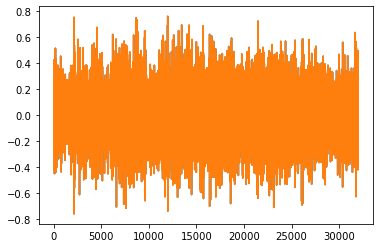

In [12]:
filename = '../data/UrbanSound8K/audio/fold1/99180-9-0-7.wav'
waveform, sample_rate = torchaudio.load(filename)

print("Shape of waveform: {}".format(waveform.size()))

print("Sample rate of waveform: {}".format(sample_rate))
plt.figure(figsize=(10, 8))
plt.figure()
plt.plot(waveform.t().numpy())

In [13]:
print('Sample Rate: ', sample_rate)

Sample Rate:  8000


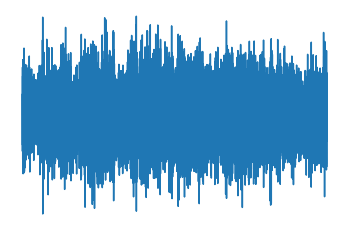

In [14]:
plt.figure()
plt.plot(waveform.mean(0).numpy())
plt.axis('off')
plt.savefig("audio_preprocessing_tutorial_waveform.png")

## Transformations

Torchaudio supports a growing list of [transformations](https://pytorch.org/audio/transforms.html>).

* **Resample**: Resample waveform to a different sample rate.
* **Spectrogram**: Create a spectrogram from a waveform.
* **MelScale**: This turns a normal STFT into a Mel-frequency STFT, using a conversion matrix.
* **SpectrogramToDB**: This turns a spectrogram from the power/amplitude scale to the decibel scale.
* **MFCC**: Create the Mel-frequency cepstrum coefficients from a waveform.
* **MelSpectrogram**: Create MEL Spectrograms from a waveform using the STFT function in PyTorch.
* **MuLawEncoding**: Encode waveform based on mu-law companding. 
* **MuLawDeconding**: Decode mu-law encoded waveform.

Since all transforms are nn.Modules or jit.ScriptModules, they can be used as part of a neural network at any point.

### Reference: https://github.com/mravanelli/SincNet
https://github.com/mechanicalsea/spectra

In [6]:
import numpy as np
import math
import torch
import torch.nn.functional as F
import torch.nn as nn
import torchaudio
import matplotlib.pyplot as plt

In [11]:
waveform, samplerate = torchaudio.load('../data/piece_20_32k.wav')
print(waveform.shape, samplerate)

torch.Size([1, 785077]) 32000


In [18]:
# set the frequency upper and lower bounds
min_band_hz = 50
min_hz = 50
max_hz = samplerate // 2 - (min_hz + min_band_hz)

print("Minimum band: {}\nMinimum frequency: {}\nMaximum frequency: {}".format(min_band_hz, min_hz, max_hz))

Minimum band: 50
Minimum frequency: 50
Maximum frequency: 15900


In [13]:
def hz2mel(hz):
    return 2595 * np.log10(1 + hz / 700.)

def mel2hz(mel):
    return 700 * (10 ** (mel / 2595.) - 1)

out_channels = 3
mel = np.linspace(hz2mel(min_hz),
                  hz2mel(max_hz),
                  num=out_channels+1)
hz = mel2hz(mel)

print('Mel:', list(mel.astype(int)))
print('Hz:', list(hz.astype(int)))

Mel: [77, 1241, 2404, 3568]
Hz: [49, 1405, 5212, 15900]


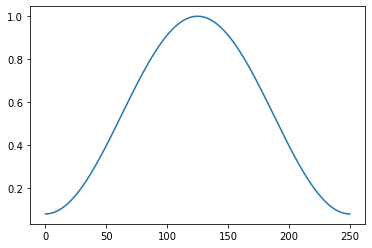

In [14]:
# Define Hamming window
kernel_size = 251

n = np.linspace(0, kernel_size, kernel_size)
window = 0.54 - 0.46 * np.cos(2 * math.pi * n / kernel_size)

plt.plot(window)

torch.Size([1, 251])
tensor([[   50.0000,  1355.7665,  1405.7665],
        [ 1405.7665,  3806.5701,  5212.3364],
        [ 5212.3364, 10687.6631, 15900.0000]])
tensor([[ 9018.3633],
        [15402.8135],
        [26034.2676]])
The shape of filters torch.Size([3, 1, 251])


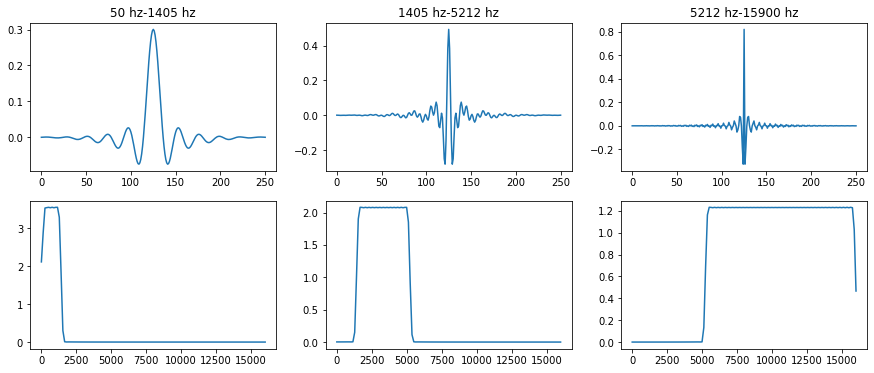

In [15]:
n = 2 * math.pi * torch.arange(-(kernel_size // 2), (kernel_size // 2) + 1).view(1, -1) / samplerate
n[n == 0] = 1e-8

low_hz = torch.Tensor(hz[:-1]).view(-1, 1)
band_hz = torch.Tensor(np.diff(hz)).view(-1, 1)
high_hz = torch.Tensor(hz[1:]).view(-1, 1)

print(n.shape)
print(torch.cat([low_hz, band_hz, high_hz], dim=1))

f_t_low = torch.matmul(low_hz, n)
f_t_high = torch.matmul(high_hz, n)

filters = ((torch.sin(f_t_high)-torch.sin(f_t_low))/(n/2))*torch.from_numpy(window).type(torch.float32)
filters[:,kernel_size//2:kernel_size//2+1] = 2. * (high_hz - low_hz)
print(torch.norm(filters, dim=1, keepdim=True))
filters = filters / torch.norm(filters, dim=1, keepdim=True)#filters / filters.max()#[:,125:126] # 权重归一化
filters = filters.view(out_channels, 1, kernel_size)

print("The shape of filters {}".format(filters.shape))

plt.figure(figsize=(15, 6))
for i in range(out_channels):
    plt.subplot(2,3,i+1)
    plt.plot(filters[i,0,:].detach().numpy())
    plt.title('%d hz-%d hz' % (low_hz[i,0], high_hz[i,0]))
    plt.subplot(2,3,i+1+3)
    plt.plot(np.linspace(0, samplerate//2, kernel_size//2+1), np.abs(np.fft.rfft(filters[i,0,:].detach().numpy())))

In [16]:
torch.norm(filters.squeeze(), dim=1, keepdim=True)

tensor([[1.0000],
        [1.0000],
        [1.0000]])

torch.Size([1, 3, 2750])


Text(0.5, 1.0, 'Original signal')

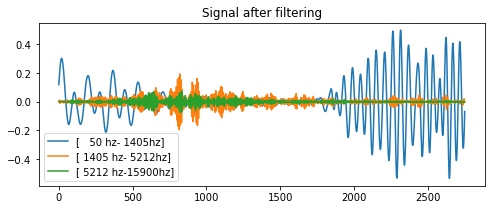

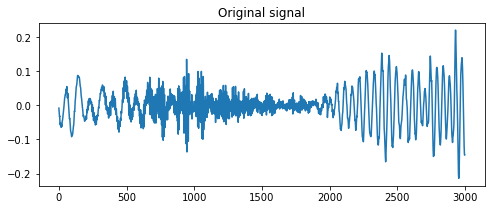

In [17]:
wav = waveform[0,:10000].view(1,1,-1)[:,:,:3000]
out = F.conv1d(wav, filters, stride=1, padding=0)
print(out.shape)
plt.figure(figsize=(8, 3))
plt.plot(out[0].t())
plt.legend(['[%5d hz-%5dhz]' % (int(low), int(high)) for low, high in zip(low_hz[:,0].numpy(), 
                                                             high_hz[:,0].numpy())], 
           loc='best', ncol=1)
plt.title('Signal after filtering')
plt.figure(figsize=(8, 3))
plt.plot(wav[0,0])
plt.title('Original signal')

### Extracting MFCC by PyTorch-style Python
MFCC is the abbreviation of Mel-Frequency Cepstral Coefficients which is important in the field of signal.

#### Overview

![overview](MFCC.png)

1. Apply **pre-emphasis** to a signal and **frame** it into overlapping frames.
2. Compute the **power spectrum** of each frame and calculate its **energy**.
3. Apply **Mel-filterbank** to the power spectrum and **log** it.
4. Compute the **DCT** of the Mel-filterbank energy features and apply **cepstral liftering** to it.

Note that energy and Mel-filterbank features **0** should be replaced to a extremely small positive number, such as 2.220446049250313e-16.

#### Load a wav

Shape of waveform: torch.Size([785077])
Sample rate of waveform: 32000


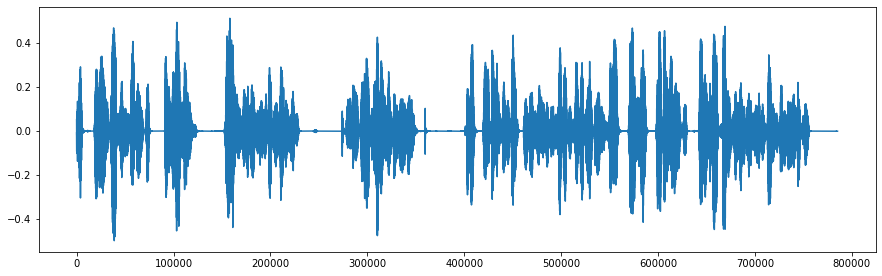

In [39]:
wav_file = '../data/piece_20_32k.wav'
signal, samplerate = torchaudio.load(wav_file)
signal = signal[0]
def wav_show(t, sr=None):
    print("Shape of waveform: {}".format(t.size()))
    if sr: print("Sample rate of waveform: {}".format(sr))
    plt.figure(figsize=(15, 4.5))
    plt.plot(t.numpy())
    plt.show()
def frame_show(t):
    print("Shape of spectrogram: {}".format(t.size()))
    plt.figure(figsize=(15, 4.5))
    plt.imshow(t.abs().numpy(), cmap='gray')
    plt.colorbar()
    plt.show()
wav_show(signal, samplerate)

#### Set parameter
- The number of cepstral coefficients: 13
- The number of filter bank: 26
- The number of fft: 512
- The length of a frame: 0.025 s
- The length of a hop: 0.01 s


In [40]:
numcep = 13
nfilt = 26
nfft = 512
winlen = 0.025
hoplen = 0.01

#### Pre-emphasis

Before we frame a signal, pro-emphasis should be firstly applied to the signal. This step is helpful to focus on formant.

Actually, pre-emphasis is as high-pass filter which is regraded as weighted with later time:

$$s(t)=s(t)-\mu \cdot s(t+1)$$

where $\mu$ is a weight parameter between $(0.9, 1.0)$, in general $0.97$.

For faster, we conduct it using a vecter-style,

$$s[1:] = s[1:]-\mu\cdot s[:-1]$$

Finally, we obtain it as

```python
signal = torch.cat((signal[0:1], signal[1:] - preemph * signal[:-1]))
```

In [41]:
def preemphasis(signal, preemph=0.97):
    """
    Pre-emphasis on the input signal
    :param signal: (time,)
    :param preemph:
    :return: (time,)
    """
    return torch.cat((signal[0:1], signal[1:] - preemph * signal[:-1]))

Shape of waveform: torch.Size([785077])
Sample rate of waveform: 32000


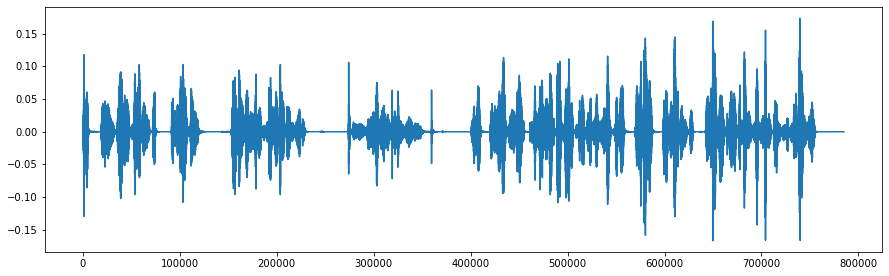

In [42]:
signal = preemphasis(signal, preemph=0.97)
wav_show(signal, samplerate)

#### Frame

After pre-emphasis, we will frame a signal in overlapping frames. The frame denotes a piece signal with the short fixed length, `winlen`.

In general, three quarters of a frame is overlapped by a following frame. So the hop of a frame, `hoplen`, is one quarter of a frame.

Actually, there is a common setting as `winlen = 0.025` and `hoplen = 0.01` which means the length of a frame is 25 ms, and the length of a hop is 10 ms.

As for digital length, the number is related to the sample rate, and we can get the real length as:

$$\text{winlen} = \text{winlen} \times \text{sample rate}$$

$$\text{hoplen} = \text{hoplen} \times \text{sample rate}$$

If you want apply a window function to a frame, it is easy to do it by the element-pair multiplying. 

In [43]:
def framesig(signal, framelen, framehop, winfunc=lambda x: torch.ones((x,))):
    """
    Frame a signal into overlapping frames.
    :param signal: (time,)
    :param framelen:
    :param framehop:
    :param winfunc:
    :return: (nframes, framelen)
    """
    slen = len(signal)
    framelen = round(framelen)  # round_half_up(framelen)
    framehop = round(framehop)  # round_half_up(framehop)
    if slen <= framelen:
        nframes = 1
    else:
        nframes = 1 + int(math.ceil((1.0 * slen - framelen) / framehop)) 

    padlen = int((nframes - 1) * framehop + framelen)

    zeros = torch.zeros((padlen - slen,))
    padsignal = torch.cat((signal, zeros))

    indices = torch.arange(0, framelen).view((1, -1)) \
              + torch.arange(0, nframes * framehop, framehop).view((-1, 1))
    frames = padsignal[indices]
    win = winfunc(framelen).view((1, -1))
    return frames * win

The length of a frame: 800, the length of a hop: 320
Shape of spectrogram: torch.Size([800, 2452])


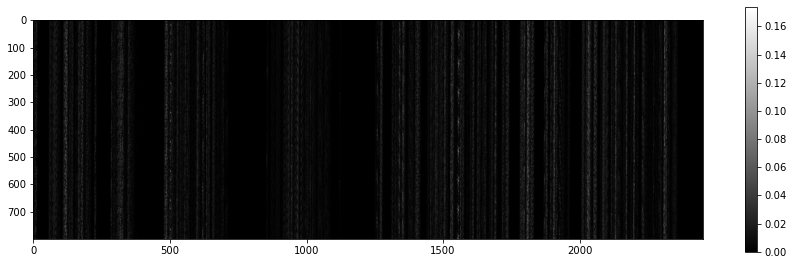

In [44]:
frames = framesig(signal, winlen*samplerate, hoplen*samplerate)
print('The length of a frame: {}, the length of a hop: {}'.format(round(winlen*samplerate), 
                                                                  round(hoplen*samplerate)))
frame_show(frames.t())

#### Power Spectrum

After framing a signal, we extract the power spectrum from each frame.

Here, `torch.rfft` is helpful to replace `numpy.fft.rfft`. Their function is same as each other.

Note that the result from `torch.rfft` is separate pairs of real and complex. So, in order to obtain power, do `torch.norm`.

In [45]:
def magspec(frames, nfft):
    """
    Compute the magnitude spectrum of each frame.
    The result of `torch.rfft` is separate pairs of real and complex.
    :param frames: (nframes, framelen)
    :param nfft:
    :return: (nframes, nfft//2+1)
    """
    if frames.shape[1] > nfft:
        logging.warning(
            'frame length (%d) is greater than FFT size (%d), frame will be truncated. Increase NFFT to avoid.',
            frames.shape[1], nfft)
        frames = frames[:, :nfft]
    else:
        frames = torch.cat((frames, torch.zeros((frames.shape[0], nfft - frames.shape[1]))), 1)
    complex_spec = torch.rfft(frames, 1)
    return torch.norm(complex_spec, dim=2)


def powspec(frames, nfft):
    """
    Compute the power spectrum of each frame.
    :param frames: (nframes, framelen)
    :param nfft:
    :return: (nframes, nfft//2+1)
    """
    return 1.0 / nfft * (magspec(frames, nfft) ** 2)

In [ ]:
import logging
pspec = powspec(frames, nfft
frame_show(pspec.log().t())

## Energy

It is easy to calculate energy of each frame by using the power spectrum.

Just do sum.

There may be a mistake if you do not care for `0` energy.

In [48]:
def get_energy(psepc):
    energy = torch.sum(pspec, 1)
    energy[energy == 0] = 2.220446049250313e-16
    return energy

In [ ]:
energy = get_energy(pspec)
wav_show(energy.log())

## Log Mel-filterbank Energy features

After power spectrum are obtained, it's time to apply mel-filterbank.

It is first to create a matrix of mel-filterbank, and then apply it on the power spectrum.

There is a paramter, the number of filters, which should be set before computing. In general, $22-26$ is okay.

Also, take care of the `0` feature.

Then, log the Mel-filterbank features.

In [33]:
def hz2mel(hz):
    """
    Convert a value in Hertz(Hz) to Mels
    :param hz: float
    :return: float
    """
    return 2595 * math.log10(1 + hz / 700.)


def mel2hz(mel):
    """
    Convert a value in Mels to Hertz(Hz).
    :param mel: float
    :return: float
    """
    return 700 * (10 ** (mel / 2595.) - 1)


def get_filterbanks(nfilt=26, nfft=512, samplerate=16000, lowfreq=0, highfreq=None):
    """
    Create a matrix of Mel-filterbank.
    :param nfilt:
    :param nfft:
    :param samplerate:
    :param lowfreq:
    :param highfreq:
    :return: (nfilt, nfft//2+1)
    """
    highfreq = highfreq or samplerate >> 1
    assert highfreq <= samplerate / 2, "highfreq is greater than samplerate/2"

    lowmel = hz2mel(lowfreq)
    highmel = hz2mel(highfreq)
    melpoints = torch.linspace(lowmel, highmel, nfilt + 2)
    bin = torch.floor((nfft + 1) * mel2hz(melpoints) / samplerate)
    
    fbank = torch.zeros((nfilt, (nfft >> 1) + 1))
    for j in range(0, nfilt):
        for i in range(int(bin[j]), int(bin[j + 1])):
            fbank[j, i] = (i - bin[j]) / (bin[j + 1] - bin[j])
        for i in range(int(bin[j + 1]), int(bin[j + 2])):
            fbank[j, i] = (bin[j + 2] - i) / (bin[j + 2] - bin[j + 1])
    return fbank  # size (nfilt, nfft//2+1)


def melfilterbank(pspec, samplerate=16000, nfilt=26, nfft=512, lowfreq=0, highfreq=None):
    """
    Compute Mel-filterbank energy features from an audio signal.
    :param signal: (time,)
    :param samplerate:
    :param winlen:
    :param hoplen:
    :param nfilt: The number of filters in the filterbank.
    :param nfft:
    :param lowfreq:
    :param highfreq:
    :param preemph:
    :param winfunc:
    :return: (nframes, nfilt), (frames,)
    """
    highfreq = highfreq or samplerate >> 1
    fb = get_filterbanks(nfilt, nfft, samplerate, lowfreq, highfreq)
    feat = torch.mm(pspec, fb.T)
    feat[feat == 0] = 2.220446049250313e-16  
    return torch.log(feat)  # feat: size (nframes, nfilt)

In [ ]:
feat = melfilterbank(pspec, nfilt=nfilt, nfft=nfft)
frame_show(feat.t())

## Cepstral Analysis

This is the last step to obtain the MFCC.

At first, the number of the cepstral should be determined.

Then, create a matrix of dct(discrete cosine transformation) and transform features a sequence of ceptral vectors.

If necessary, Apply a cepstral lifter to the matrix of cepstra.

In [36]:
def lifter(cepstra, ceplifter=22):
    """
    Apply a cepstral lifter to the matrix of cepstra.
    :param cepstra: (nframes, numcep)
    :param ceplifter:
    :return: (nframes, numcep)
    """
    if ceplifter > 0:
        nframes, numcep = cepstra.shape
        lift = 1 + (ceplifter / 2.) * torch.sin(math.pi * torch.arange(numcep) / ceplifter)
        return lift * cepstra
    else:
        return cepstra

def mfcc(feat, energy, numcep=13, nfilt=26, nfft=None, ceplifter=22, plusEnergy=True):
    """
    Compute MFCC from an audio signal.
    """
    feat = feat.mm(AF.create_dct(numcep, nfilt, norm='ortho'))
    feat = lifter(feat, ceplifter)
    if plusEnergy: feat[:, 0] = torch.log(energy)
    return feat

In [ ]:
feat = mfcc(feat, energy, numcep=numcep, nfilt=nfilt)
frame_show(feat.t())